## Model

In [1]:
# Import libraries
!pip install pulp

import pandas as pd
import numpy as np
import cvxpy as cp
from sentence_transformers import SentenceTransformer, util
from scipy.optimize import linprog
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpInteger, LpBinary
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 59.2 MB/s eta 0:00:00


In [2]:
# Data

df_instagram_influencers = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/instagram_influencers_final.csv")
df_labeled_caption = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/labeled_caption.csv")
df_labeled_comment = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/labeled_comment.csv")
df_bio = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/bio.csv")
df_captions = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/captions.csv")

In [3]:
# Kelas untuk optimasi pemilihan influencer berdasarkan budget dan estimasi impact
class BudgetOptimizer:
    def __init__(self):
        pass

    def filter_and_optimize(self, brief_budget, influencers_df):
        """Filter influencers by budget + find optimal content mix"""
        filtered_influencers = []

        for _, infl in influencers_df.iterrows():
            if (brief_budget >= infl['rate_card_story'] or
                brief_budget >= infl['rate_card_feeds'] or
                brief_budget >= infl['rate_card_reels']):

                optimal_mix = self.optimize_content_mix(
                    budget=brief_budget,
                    story_rate=infl['rate_card_story'],
                    feeds_rate=infl['rate_card_feeds'],
                    reels_rate=infl['rate_card_reels'],
                    story_impact=self.estimate_story_impact(infl),
                    feeds_impact=self.estimate_feeds_impact(infl),
                    reels_impact=self.estimate_reels_impact(infl)
                )

                infl_dict = infl.to_dict()
                infl_dict.update({
                    'optimal_content_mix': optimal_mix,
                    'budget_efficiency': optimal_mix['total_impact'] / optimal_mix['total_cost'] if optimal_mix['total_cost'] > 0 else 0
                })
                filtered_influencers.append(infl_dict)

        return pd.DataFrame(filtered_influencers)

    def optimize_content_mix(self, budget, story_rate, feeds_rate, reels_rate, story_impact, feeds_impact, reels_impact):
        prob = LpProblem("OptimalContentMix", LpMaximize)

        x = LpVariable("story_count", 0, 5, cat=LpInteger)
        y = LpVariable("feeds_count", 0, 4, cat=LpInteger)
        z = LpVariable("reels_count", 0, 3, cat=LpInteger)

        use_story = LpVariable("use_story", 0, 1, LpBinary)
        use_feeds = LpVariable("use_feeds", 0, 1, LpBinary)
        use_reels = LpVariable("use_reels", 0, 1, LpBinary)

        prob += story_rate * x + feeds_rate * y + reels_rate * z <= budget

        prob += x >= 1 * use_story
        prob += x <= 1000 * use_story

        prob += y >= 1 * use_feeds
        prob += y <= 1000 * use_feeds

        prob += z >= 1 * use_reels
        prob += z <= 1000 * use_reels

        diversity_bonus = 5 * (use_story + use_feeds + use_reels)
        prob += story_impact * x + feeds_impact * y + reels_impact * z + diversity_bonus

        prob.solve()

        story_count = int(x.varValue)
        feeds_count = int(y.varValue)
        reels_count = int(z.varValue)
        total_cost = story_count * story_rate + feeds_count * feeds_rate + reels_count * reels_rate
        total_impact = story_count * story_impact + feeds_count * feeds_impact + reels_count * reels_impact
        remaining_budget = budget - total_cost

        return {
            'story_count': story_count,
            'feeds_count': feeds_count,
            'reels_count': reels_count,
            'total_cost': total_cost,
            'total_impact': total_impact,
            'remaining_budget': remaining_budget
        }

    def estimate_story_impact(self, influencer):
        """Estimate impact score for Instagram Story"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        tier_multiplier = {
            'Nano': 1.2, 'Micro': 1.1, 'Mid': 1.0, 'Macro': 0.9, 'Mega': 0.8
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * 0.7

    def estimate_feeds_impact(self, influencer):
        """Estimate impact score for Instagram Feeds"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        tier_multiplier = {
            'Nano': 1.2, 'Micro': 1.1, 'Mid': 1.0, 'Macro': 0.9, 'Mega': 0.8
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * 1.0

    def estimate_reels_impact(self, influencer):
        """Estimate impact score for Instagram Reels"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        viral_bonus = 1.5 if influencer.get('trending_status', False) else 1.2
        tier_multiplier = {
            'Nano': 1.3, 'Micro': 1.2, 'Mid': 1.1, 'Macro': 1.0, 'Mega': 0.9
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * viral_bonus

# Kelas untuk menghitung kecocokan persona brief dan influencer secara semantic (NLP)
class PersonaSemanticMatcher:
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2'):
        self.model = SentenceTransformer(model_name)

    def prepare_influencer_texts(self, bio_df, caption_df, max_posts=5):
        """
        Prepare influencer texts dari bio dan captions untuk similarity calculation
        """
        influencer_texts = {}
        grouped_captions = caption_df.groupby('instagram_account')

        for _, row in bio_df.iterrows():
            account = row['instagram_account']
            bio = str(row['bio']) if pd.notna(row['bio']) else ""

            captions = []
            if account in grouped_captions.groups:
                captions_raw = grouped_captions.get_group(account)['post_caption'].head(max_posts)
                captions = [str(c) for c in captions_raw if pd.notna(c)]

            full_text = bio + ' ' + ' '.join(captions)
            influencer_texts[account] = full_text.strip()

        return influencer_texts

    def calculate_similarity_scores(self, brief_persona_text, influencer_texts):
        """
        Hitung cosine similarity antara brief persona dan teks masing-masing influencer.
        """
        scores = {}
        brief_vec = self.model.encode(brief_persona_text)

        accounts = list(influencer_texts.keys())
        texts = list(influencer_texts.values())

        infl_vecs = self.model.encode(texts, show_progress_bar=False)
        cosine_scores = cosine_similarity([brief_vec], infl_vecs)[0]
        scores = dict(zip(accounts, cosine_scores))

        return scores

    def get_scored_df(self, brief_persona_text, bio_df, caption_df):
        """
        Mengembalikan DataFrame berisi akun influencer dan skor kecocokan persona.
        """
        influencer_texts = self.prepare_influencer_texts(bio_df, caption_df)
        scores = self.calculate_similarity_scores(brief_persona_text, influencer_texts)
        return pd.DataFrame([
            {'instagram_account': account, 'persona_fit_score': score}
            for account, score in scores.items()
        ])

# Kelas untuk audience matching menggunakan JSON-based approach dengan flexible weighting
class AudienceMatchingGNN:
    def __init__(self, default_weights=None):
        """
        Initialize audience matcher dengan flexible weight system
        """
        self.default_weights = default_weights or {
            "location": 0.4,
            "age": 0.3,
            "gender": 0.3
        }

        # Predefined weight strategies untuk different business scenarios
        self.weight_strategies = {
            "balanced": {"location": 0.33, "age": 0.33, "gender": 0.34},
            "location_focused": {"location": 0.6, "age": 0.25, "gender": 0.15},
            "demographic_focused": {"location": 0.2, "age": 0.4, "gender": 0.4},
            "age_priority": {"location": 0.2, "age": 0.6, "gender": 0.2},
            "gender_priority": {"location": 0.15, "age": 0.25, "gender": 0.6},
            "geo_only": {"location": 1.0, "age": 0.0, "gender": 0.0},
            "demo_only": {"location": 0.0, "age": 0.5, "gender": 0.5}
        }

    def get_weight_strategy(self, strategy_name):
        """Get predefined weight strategy"""
        return self.weight_strategies.get(strategy_name, self.default_weights)

    def calculate_audience_match_score(self, brief_audience, influencer_audience, weights=None, strategy=None):
        """
        Calculate audience match score dengan real Instagram insights data
        """
        # Priority: custom weights > strategy > default
        if weights is not None:
            used_weights = weights
        elif strategy is not None:
            used_weights = self.get_weight_strategy(strategy)
        else:
            used_weights = self.default_weights

        # Normalize weights
        total_weight = sum(used_weights.values())
        if abs(total_weight - 1.0) > 0.01:
            used_weights = {k: v/total_weight for k, v in used_weights.items()}

        # Calculate component scores
        location_score = self._calculate_location_score(brief_audience, influencer_audience)
        age_score = self._calculate_age_score(brief_audience, influencer_audience)
        gender_score = self._calculate_gender_score(brief_audience, influencer_audience)

        # Weighted total
        total_score = (
            location_score * used_weights["location"] +
            age_score * used_weights["age"] +
            gender_score * used_weights["gender"]
        )

        return {
            "location_score": round(location_score, 3),
            "age_score": round(age_score, 3),
            "gender_score": round(gender_score, 3),
            "total_score": round(total_score, 3),
            "weights_used": used_weights,
            "strategy_used": strategy or "custom"
        }

    def _calculate_location_score(self, brief, influencer):
        """Calculate location overlap score using REAL Instagram insights"""
        if "top_locations" not in brief or "top_locations" not in influencer:
            return 0.0

        brief_countries = set(brief["top_locations"].get("countries", []))
        brief_cities = set(brief["top_locations"].get("cities", []))

        country_score = sum(
            loc["percent"] for loc in influencer["top_locations"].get("countries", [])
            if loc["country"] in brief_countries
        )
        city_score = sum(
            loc["percent"] for loc in influencer["top_locations"].get("cities", [])
            if loc["city"] in brief_cities
        )

        return (country_score + city_score) / 200

    def _calculate_age_score(self, brief, influencer):
        """Calculate age overlap score using REAL Instagram insights"""
        if "age_range" not in brief or "age_range_overall" not in influencer:
            return 0.0

        brief_age = set(brief["age_range"])
        return sum(
            a["percent"] for a in influencer["age_range_overall"]
            if a["range"] in brief_age
        ) / 100

    def _calculate_gender_score(self, brief, influencer):
        """Calculate gender overlap score using REAL Instagram insights"""
        if "gender" not in brief or "gender_overall" not in influencer:
            return 0.0

        brief_gender = set(brief["gender"])
        return sum(
            g["percent"] for g in influencer["gender_overall"]
            if g["gender"] in brief_gender
        ) / 100

    def calculate_demographic_similarity(self, brief_data, influencer_data):
        """
        Backward compatibility dengan format lama - akan menggunakan extract functions
        """
        try:
            # Extract audience data using real data functions
            if 'audience_preference' in brief_data:
                brief_audience = json.loads(brief_data['audience_preference'])
            else:
                # Fallback for old format
                brief_audience = {
                    "top_locations": {"countries": ["Indonesia"], "cities": ["Jakarta"]},
                    "age_range": ["18-24", "25-34"],
                    "gender": ["Female", "Male"]
                }

            if 'audience_analytics' in influencer_data:
                infl_audience = json.loads(influencer_data['audience_analytics'])
            else:
                # Fallback for old format
                infl_audience = {
                    "top_locations": {"countries": [{"country": "Indonesia", "percent": 80}], "cities": []},
                    "age_range_overall": [{"range": "18-24", "percent": 50}],
                    "gender_overall": [{"gender": "Female", "percent": 60}]
                }

            result = self.calculate_audience_match_score(brief_audience, infl_audience, strategy="balanced")
            return result["total_score"]

        except Exception as e:
            print(f"Error in demographic similarity: {e}")
            return 0.5  # Default score if error

# Kelas untuk prediksi performa campaign influencer secara heuristik
class SocialMediaPerformancePredictor:
    def __init__(self):
        self.tier_benchmarks = {
            'Nano': {'engagement': 0.04, 'views': 5000},
            'Micro': {'engagement': 0.02, 'views': 25000},
            'Mid': {'engagement': 0.015, 'views': 75000},
            'Macro': {'engagement': 0.012, 'views': 200000},
            'Mega': {'engagement': 0.01, 'views': 500000}
        }

    def predict_campaign_performance(self, influencer_data, brief_data):
        """Predict campaign performance using heuristic approach"""
        # Calculate performance components
        engagement_score = self.calculate_engagement_score(influencer_data)
        authenticity_score = self.calculate_authenticity_score(influencer_data)
        reach_potential = self.calculate_reach_potential(influencer_data)
        brief_fit = self.calculate_brief_fit(influencer_data, brief_data)

        # Combined performance score
        performance_score = (
            engagement_score * 0.3 +
            authenticity_score * 0.25 +
            reach_potential * 0.25 +
            brief_fit * 0.2
        )

        return {
            'performance_score': min(performance_score, 1.0),
            'engagement_score': engagement_score,
            'authenticity_score': authenticity_score,
            'reach_potential': reach_potential,
            'brief_fit': brief_fit
        }

    def calculate_engagement_score(self, influencer_data):
        """Calculate engagement quality score"""
        er = influencer_data.get('engagement_rate_pct', 0)
        tier = influencer_data.get('tier_followers', 'Micro')
        benchmark = self.tier_benchmarks.get(tier, {'engagement': 0.02})['engagement']

        normalized_er = min(er / benchmark, 2.0) if benchmark > 0 else 0
        return normalized_er / 2.0

    def calculate_authenticity_score(self, influencer_data):
        """Calculate authenticity based on endorse rate and consistency"""
        endorse_rate = influencer_data.get('random_endorse_rate', 0.5)
        consistency = influencer_data.get('behavior_consistency', False)

        authenticity = (1 - endorse_rate) * 0.7
        if consistency:
            authenticity += 0.3

        return min(authenticity, 1.0)

    def calculate_reach_potential(self, influencer_data):
        """Calculate reach potential based on views and virality"""
        avg_views = influencer_data.get('avg_reels_views', 0)
        trending = influencer_data.get('trending_status', False)
        tier = influencer_data.get('tier_followers', 'Micro')

        benchmark = self.tier_benchmarks.get(tier, {'views': 25000})['views']
        view_score = min(avg_views / benchmark, 2.0) / 2.0 if benchmark > 0 else 0

        if trending:
            view_score *= 1.2

        return min(view_score, 1.0)

    def calculate_brief_fit(self, influencer_data, brief_data):
        """Calculate brief-influencer fit score"""
        industry_match = 0.5
        if influencer_data.get('expertise_field', '').lower() in brief_data.get('industry', '').lower():
            industry_match = 0.8

        tier = influencer_data.get('tier_followers', 'Micro')
        budget = brief_data.get('budget', 0)

        # Budget appropriateness
        if tier == 'Nano' and budget < 50000000:
            budget_fit = 0.9
        elif tier == 'Micro' and 20000000 <= budget <= 200000000:
            budget_fit = 0.8
        elif tier == 'Mid' and 100000000 <= budget <= 500000000:
            budget_fit = 0.8
        else:
            budget_fit = 0.6

        return (industry_match + budget_fit) / 2

# Kelas untuk ranking akhir dengan multiple objective
class MultiObjectiveRanker:
    def __init__(self):
        pass

    def rank_influencers(self, scored_influencers, priorities):
        """Rank influencers berdasarkan weighted multiple objectives"""
        ranked_results = []

        for influencer in scored_influencers:
            final_score = 0
            for criterion, weight in priorities.items():
                score = influencer.get(criterion, 0)
                final_score += score * weight

            result = influencer.copy()
            result['final_score'] = final_score
            ranked_results.append(result)

        # Sort by final score descending
        ranked_results.sort(key=lambda x: x['final_score'], reverse=True)
        return ranked_results

# Main SOTAInfluencerMatcher Class
class SOTAInfluencerMatcher:
    def __init__(self):
        """Initialize dengan semua komponen yang sudah ditest"""
        self.budget_optimizer = BudgetOptimizer()
        self.persona_matcher = PersonaSemanticMatcher()
        self.audience_matcher = AudienceMatchingGNN()
        self.performance_predictor = SocialMediaPerformancePredictor()
        self.final_ranker = MultiObjectiveRanker()

    def extract_brief_audience_preference(self, brief_row):
        """Extract audience preference dari brief data - REAL FORMAT"""
        try:
            audience_pref_str = brief_row['audience_preference']
            audience_pref = json.loads(audience_pref_str)
            return audience_pref
        except Exception as e:
            return {
                "top_locations": {"countries": ["Indonesia"], "cities": ["Jakarta"]},
                "age_range": ["18-24", "25-34"],
                "gender": ["Female", "Male"]
            }

    def extract_influencer_audience_analytics(self, influencer_row):
        """Extract audience analytics dari influencer data - REAL Instagram Insights"""
        try:
            audience_analytics_str = influencer_row['audience_analytics']
            audience_analytics = json.loads(audience_analytics_str)
            return audience_analytics
        except Exception as e:
            return {
                "top_locations": {"countries": [], "cities": []},
                "age_range_overall": [],
                "gender_overall": []
            }

import json

In [4]:
# MAIN FUNCTIONS

def get_top_influencers_for_brief(brief_id, briefs_df, influencers_df, bio_df, caption_df, top_n=5, brief_priorities=None):
    """
    UPDATED: Get top influencers untuk brief dengan real data integration
    """
    if brief_priorities is None:
        brief_priorities = {
            'persona_fit': 0.25,
            'audience_fit': 0.25,
            'performance_pred': 0.25,
            'budget_efficiency': 0.25
        }

    # Initialize matcher dengan improved components
    matcher = SOTAInfluencerMatcher()

    # Get brief data
    brief_data = briefs_df[briefs_df['brief_id'] == brief_id]
    if brief_data.empty:
        print(f"Brief '{brief_id}' tidak ditemukan")
        return []

    brief_row = brief_data.iloc[0]

    try:
        # Step 1: Budget filtering
        affordable_influencers = matcher.budget_optimizer.filter_and_optimize(
            brief_row['budget'], influencers_df
        )

        if affordable_influencers.empty:
            print(f"Tidak ada influencer yang affordable untuk budget Rp {brief_row['budget']:,}")
            return []

        # print(f"✅ Budget filtering: {len(affordable_influencers)} influencers affordable")

        # Step 2: Persona matching
        persona_scores_df = matcher.persona_matcher.get_scored_df(
            brief_persona_text=brief_row['influencer_persona'],
            bio_df=bio_df,
            caption_df=caption_df
        )

        # Merge persona scores
        affordable_influencers = pd.merge(
            affordable_influencers,
            persona_scores_df.rename(columns={'persona_fit_score': 'persona_fit'}),
            left_on='username_instagram',
            right_on='instagram_account',
            how='left'
        )
        affordable_influencers['persona_fit'] = affordable_influencers['persona_fit'].fillna(0.5)

        # print(f"✅ Persona matching: scores calculated")

        # Step 3: Audience matching menggunakan REAL data
        brief_audience = matcher.extract_brief_audience_preference(brief_row)

        scored_influencers = []
        for _, infl in affordable_influencers.iterrows():
            # Extract real audience analytics
            infl_audience = matcher.extract_influencer_audience_analytics(infl)

            # Calculate audience match menggunakan AudienceMatchingGNN
            audience_result = matcher.audience_matcher.calculate_audience_match_score(
                brief_audience, infl_audience, strategy="balanced"
            )

            # Performance prediction
            performance_result = matcher.performance_predictor.predict_campaign_performance(
                infl.to_dict(), brief_row.to_dict()
            )

            scored_influencers.append({
                'influencer': infl['username_instagram'],
                'persona_fit': infl.get('persona_fit', 0.5),
                'audience_fit': audience_result['total_score'],  # Real audience matching
                'performance_pred': performance_result['performance_score'],
                'budget_efficiency': infl['budget_efficiency'],
                'tier': infl['tier_followers'],
                'expertise': infl['expertise_field'],
                # Additional fields untuk format InfluencerMatcher
                'engagement_rate': infl.get('engagement_rate_pct', 0),
                'authenticity_score': performance_result.get('authenticity_score', 0),
                'reach_potential': performance_result.get('reach_potential', 0),
                'brand_fit': performance_result.get('brand_fit', 0),
                'optimal_content_mix': infl.get('optimal_content_mix', {}),
                'raw_influencer_data': infl.to_dict()
            })

        # print(f"✅ Audience & Performance scoring: {len(scored_influencers)} influencers scored")

        # Step 4: Final ranking
        ranked_results = matcher.final_ranker.rank_influencers(scored_influencers, brief_priorities)

        # print(f"✅ Final ranking completed")
        return ranked_results[:top_n]

    except Exception as e:
        print(f"❌ Error in get_top_influencers_for_brief: {e}")
        import traceback
        traceback.print_exc()
        return []

def generate_brief_summary(briefs_df, brief_id):
    """Generate brief summary dengan informasi lengkap"""
    brief_data = briefs_df[briefs_df['brief_id'] == brief_id]
    if brief_data.empty:
        return f"Brief '{brief_id}' tidak ditemukan"

    brief = brief_data.iloc[0]

    # Format budget
    budget_str = f"Rp {brief['budget']:,}"

    # Extract audience preference
    try:
        audience_pref = json.loads(brief['audience_preference'])
        target_countries = ", ".join(audience_pref['top_locations']['countries'][:3])
        target_cities = ", ".join(audience_pref['top_locations']['cities'][:3])
        target_age = ", ".join(audience_pref['age_range'])
        target_gender = ", ".join(audience_pref['gender'])
    except:
        target_countries = "Indonesia"
        target_cities = "Jakarta"
        target_age = "18-34"
        target_gender = "All"

    summary = f"""
{brief['product_name']}

🏢 Industry: {brief['industry']}
💰 Budget: {budget_str}
🎯 Target Audience:
   📍 Countries: {target_countries}
   🏙️ Cities: {target_cities}
   👥 Age Range: {target_age}
   ⚧ Gender: {target_gender}
📝 Influencer Persona: {brief['influencer_persona'][:150]}...
"""
    return summary

def generate_influencer_insight(username, caption_df, comment_df, show_plot=False):
    """
    Generate detailed insight untuk influencer berdasarkan caption dan comment
    Format output sama seperti InfluencerMatcher.ipynb
    """
    result = f"🔁 Conversion Potential for @{username}\n"

    captions = caption_df[caption_df["instagram_account"] == username]
    comments = comment_df[comment_df["instagram_account"] == username]

    # --- Comment Insight ---
    comment_counts = None
    if not comments.empty:
        comment_counts = comments["predicted_label"].value_counts(normalize=True).mul(100).round(1)
        total_comments = len(comments)
        result += f"\n💬 Comment Quality\nTotal {total_comments} komentar dianalisis.\n"

        # Narasi persentase tiap label
        for label, pct in comment_counts.items():
            label_id = label.lower().replace("_", " ")
            result += f"{pct:.1f}% {label_id}\n"

        # High-value comment rate
        high_value_labels = ["relatable engagement", "product-focused response", "social virality"]
        high_value_pct = sum([comment_counts.get(lbl, 0) for lbl in comment_counts.index if lbl.lower() in high_value_labels])
        result += f"🎯 High-Value Comment Rate: {high_value_pct:.1f}%\n"
        if high_value_pct < 20:
            result += "⚠️ Low engagement quality - mostly passive comments\n"

        result += "\n💬 Komentar Berkualitas Tinggi yang Mewakili Audiens\n"
        for label in high_value_labels:
            label_comments = comments[comments["predicted_label"].str.lower() == label]
            if not label_comments.empty:
                result += f"\n🔹 {label.title()}\n"
                example = label_comments["comment"].iloc[0]
                result += f'Contoh:\n"{example}"\n'
            else:
                if label == "product-focused response":
                    result += "\n🔹 Product-Focused Response (minat terhadap produk)\nTidak ditemukan komentar yang membahas produk secara langsung pada postingan terakhir.\n"

        if total_comments < 20:
            result += f"\n⚠️ Hanya {total_comments} komentar terdeteksi. Insight ini mungkin kurang representatif karena volume interaksi yang rendah.\n"
    else:
        result += "\nTidak ada komentar yang dapat dianalisis.\n"

    # --- Caption Insight ---
    result += f"\n📢 Caption Behavior Summary – Influencer: {username}\n"
    caption_counts = None
    if not captions.empty:
        # Call-to-action habit
        cta_labels = ["call-to-action", "engagement-inviting"]
        cta_count = captions["predicted_label"].str.lower().isin(cta_labels).sum()
        total_captions = len(captions)
        result += f"\n🔁 Call-to-Action Habit:\n{cta_count} dari {total_captions} caption mengandung CTA.\n"
        if cta_count > 0:
            example_cta = captions[captions["predicted_label"].str.lower().isin(cta_labels)]["post_caption"].iloc[0]
            result += f'Contoh:\n"{example_cta[:120]}..."\n'

        # Product mention
        prod_labels = ["product-focused", "brand awareness"]
        prod_count = captions["predicted_label"].str.lower().isin(prod_labels).sum()
        if prod_count > 0:
            example_prod = captions[captions["predicted_label"].str.lower().isin(prod_labels)]["post_caption"].iloc[0]
            result += f'\n🛍️ Product Mention:\n{prod_count} caption menyebut produk atau brand.\nContoh:\n"{example_prod[:120]}..."\n'

        # Tone of voice
        caption_counts = captions["predicted_label"].value_counts()
        dominant_label = caption_counts.idxmax()
        result += f"\n🎭 Tone of Voice:\nDominan: {dominant_label}.\n"
        example_tone = captions[captions["predicted_label"] == dominant_label]["post_caption"].iloc[0]
        result += f'Contoh:\n"{example_tone[:120]}..."\n'

        result += f"\n📊 Distribusi label utama:\n"
        for lbl, cnt in caption_counts.items():
            result += f"{lbl}: {cnt}\n"

        if "brand awareness" in caption_counts.index:
            result += "\n💡 Insight:\nGaya caption menunjukkan fokus pada membangun kesadaran merek, cocok untuk kampanye awareness.\n"
        if cta_count > 0:
            result += "Juga ditemukan upaya interaksi dua arah dengan audiens.\n"
    else:
        result += "\nTidak ada caption yang dapat dianalisis.\n"

    # Add plot functionality
    if show_plot and (caption_counts is not None or comment_counts is not None):
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        if caption_counts is not None:
            sns.barplot(x=caption_counts.index, y=caption_counts.values, palette="pastel", ax=axes[0])
            axes[0].set_title("Caption Label Distribution")
            axes[0].set_ylabel("Count")
            axes[0].set_xlabel("Caption Label")
            axes[0].tick_params(axis='x', rotation=30)
        else:
            axes[0].axis('off')
            axes[0].set_title("No Caption Data")

        if comment_counts is not None:
            sns.barplot(x=comment_counts.index, y=comment_counts.values, palette="muted", ax=axes[1])
            axes[1].set_title("Comment Label Distribution (%)")
            axes[1].set_ylabel("Percentage (%)")
            axes[1].set_xlabel("Comment Label")
            axes[1].tick_params(axis='x', rotation=30)
        else:
            axes[1].axis('off')
            axes[1].set_title("No Comment Data")

        plt.suptitle(f"@{username} Content & Audience Label Distribution", fontsize=13, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return result.strip()

# MAIN DISPLAY FUNCTION

def display_brief_recommendation(brief_id, briefs_df, influencers_df, caption_df, comment_df, bio_df, top_n=3, brief_priorities=None):
    """
    UPDATED: Display brief summary and top influencer recommendations dengan real data
    """
    print(f"\n{'='*80}")
    print(f"🎯 INFLUENCER RECOMMENDATION SYSTEM")
    print(f"{'='*80}")

    # Get recommendations menggunakan updated system
    recommendations = get_top_influencers_for_brief(
        brief_id, briefs_df, influencers_df, bio_df, caption_df, top_n, brief_priorities
    )

    if not recommendations:
        print("❌ No recommendations found.")
        return

    # Display Brief Summary
    print(f"\n📊 BRIEF SUMMARY: {brief_id.upper()}")
    print(f"{'='*60}")
    print(generate_brief_summary(briefs_df, brief_id))

    print(f"\n🏆 TOP {top_n} INFLUENCER RECOMMENDATIONS:")
    print(f"{'='*60}")

    for i, rec in enumerate(recommendations, 1):
        tier_emoji = {
            "Nano": "🔥", "Micro": "⭐", "Mid": "🚀",
            "Macro": "💎", "Mega": "👑"
        }.get(rec['tier'], "📱")

        print(f"\n{i}. {tier_emoji} @{rec['influencer']} ({rec['tier']} Influencer)")
        print(f"   📊 Overall Match Score: {rec['final_score']:.1%}")

        # Add content insights dengan show_plot=True
        insight = generate_influencer_insight(
            username=rec['influencer'],
            caption_df=caption_df,
            comment_df=comment_df,
            show_plot=True
        )

        # Print insight dengan format yang sama seperti InfluencerMatcher
        for line in insight.split("\n"):
            print(f"   {line}")

        print(f"\n   🎯 Score Breakdown:")
        print(f"      • Budget Efficiency:      {rec['budget_efficiency'] * 1_000_000:.2f} points/Million Rp")
        print(f"      • Persona Fit:           {rec['persona_fit']:.1%}")
        print(f"      • Audience Match:        {rec['audience_fit']:.1%}")
        print(f"      • Performance Potential: {rec['performance_pred']:.1%}")

        print(f"\n   📈 Performance Metrics:")
        print(f"      • Engagement Rate:       {rec.get('engagement_rate', 0):.2%}")
        print(f"      • Authenticity Score:    {rec.get('authenticity_score', 0):.1%}")
        print(f"      • Reach Potential:       {rec.get('reach_potential', 0):.1%}")
        print(f"      • Brand Alignment:       {rec.get('brand_fit', 0):.1%}")

        print(f"\n   💰 Optimal Campaign Strategy:")
        mix = rec.get('optimal_content_mix', {})
        if mix.get('story_count', 0) > 0:
            print(f"      • Instagram Stories: {mix['story_count']} posts")
        if mix.get('feeds_count', 0) > 0:
            print(f"      • Feed Posts: {mix['feeds_count']} posts")
        if mix.get('reels_count', 0) > 0:
            print(f"      • Reels: {mix['reels_count']} posts")

        print(f"\n   💳 Financial Summary:")
        print(f"      • Total Investment:      Rp {mix.get('total_cost', 0):,}")
        print(f"      • Budget Remaining:      Rp {mix.get('remaining_budget', 0):,}")
        print(f"      • Expected Impact:       {mix.get('total_impact', 0):.1f} points")

        # Key Insights section
        raw_data = rec.get('raw_influencer_data', {})
        insights = []
        if raw_data.get('trending_status', False):
            insights.append("🔥 Currently trending")
        if raw_data.get('behavior_consistency', False):
            insights.append("✅ Consistent content behavior")
        if raw_data.get('campaign_success_signif', False):
            insights.append("🎯 Proven campaign success")
        if raw_data.get('random_endorse_rate', 1) < 0.3:
            insights.append("🏅 Low endorsement frequency (authentic)")
        elif raw_data.get('random_endorse_rate', 1) > 0.7:
            insights.append("⚠️ High endorsement frequency")

        if insights:
            print(f"\n   💡 Key Insights:")
            for insight_text in insights:
                print(f"      • {insight_text}")

        if i < len(recommendations):
            print(f"\n{'-' * 80}")

    # Show strategy used
    if brief_priorities:
        print(f"\n🎛️ Ranking Strategy Used:")
        for component, weight in brief_priorities.items():
            print(f"   • {component.replace('_', ' ').title()}: {weight:.1%}")

    print(f"\n✅ RECOMMENDATION COMPLETE")
    print(f"💡 Using Real Instagram Insights for Audience Matching")
    print(f"🚀 Powered by AudienceMatchingGNN + Multi-Component Analysis")


## Example Usage

In [5]:
# Contoh penggunaan dengan JSON input brief - NANTI KITA DAPETIN DARI FRONT END WEB

sample_json_brief = {
  "brief_id": "BRIEF_001",
  "brand_name": "Avoskin",
  "industry": "Skincare & Beauty",
  "product_name": "GlowSkin Vitamin C Serum",
  "overview": "Premium vitamin C serum untuk mencerahkan dan melindungi kulit dari radikal bebas",
  "usp": "Formula 20% Vitamin C dengan teknologi nano-encapsulation untuk penetrasi optimal",
  "marketing_objective": [
    "Cognitive",
    "Affective"
  ],
  "target_goals": [
    "Follower Growth",
    "Customer Retention"
  ],
  "timing_campaign": "2025-02-15",
  "audience_preference": {
    "top_locations": {
      "countries": [
        "Indonesia",
        "Malaysia",
        "Singapore"
      ],
      "cities": [
        "Jakarta",
        "Surabaya",
        "Bandung",
        "Kuala Lumpur"
      ]
    },
    "age_range": [
      "18-24",
      "25-34"
    ],
    "gender": [
      "Female"
    ]
  },
  "influencer_persona": "Beauty enthusiast, skincare expert, authentic product reviewer",
  "total_influencer": 2,
  "niche": [
    "Beauty",
    "Lifestyle"
  ],
  "location_prior": [
    "Indonesia",
    "Malaysia"
  ],
  "esg_allignment": [
    "Cruelty-free",
    "sustainable packaging"
  ],
  "budget": 50000000.0,
  "output": {
    "content_types": [
      "Reels",
      "Feeds"
    ],
    "deliverables": 6
  },
  "risk_tolerance": "Medium"
}


In [6]:
# mengkonversi input JSON brief menjadi format yang sesuai dengan sistem

def process_json_brief_input(json_brief_input, influencers_df, caption_df, comment_df, bio_df, brief_priorities=None):
    """
    Fungsi untuk memproses input JSON brief dan menjalankan rekomendasi influencer

    Parameters:
    - json_brief_input: dict - JSON input brief dari user
    - influencers_df: DataFrame - data influencer Instagram
    - caption_df: DataFrame - data caption terklasifikasi
    - comment_df: DataFrame - data comment terklasifikasi
    - bio_df: DataFrame - data bio influencer
    - brief_priorities: dict - prioritas komponen scoring (opsional)

    Returns:
    - Menampilkan rekomendasi influencer dan mengembalikan hasil
    """

    # 1. Konversi JSON input menjadi DataFrame brief
    brief_df = convert_json_to_brief_dataframe(json_brief_input)

    # 2. Ekstrak brief_id dan top_n dari JSON
    brief_id = json_brief_input.get("brief_id")
    top_n = json_brief_input.get("total_influencer", 3)  # default 3 jika tidak ada

    # 3. Set default brief_priorities jika tidak disediakan
    if brief_priorities is None:
        brief_priorities = {
            'persona_fit': 0.1,
            'audience_fit': 0.45,
            'performance_pred': 0.35,
            'budget_efficiency': 0.1
        }

    # 4. Jalankan display_brief_recommendation dengan parameter yang sudah dikonversi
    return display_brief_recommendation(
        brief_id=brief_id,
        briefs_df=brief_df,
        influencers_df=influencers_df,
        caption_df=caption_df,
        comment_df=comment_df,
        bio_df=bio_df,
        top_n=top_n,
        brief_priorities=brief_priorities
    )

def convert_json_to_brief_dataframe(json_brief):
    """
    Mengkonversi JSON brief menjadi DataFrame dengan format yang sesuai

    Parameters:
    - json_brief: dict - JSON input brief

    Returns:
    - DataFrame dengan satu baris berisi data brief
    """
    import json

    # Konversi list dan dict menjadi string JSON untuk kompatibilitas dengan DataFrame
    brief_data = {
        'brief_id': json_brief.get('brief_id'),
        'brand_name': json_brief.get('brand_name'),
        'industry': json_brief.get('industry'),
        'product_name': json_brief.get('product_name'),
        'overview': json_brief.get('overview'),
        'usp': json_brief.get('usp'),
        'marketing_objective': json.dumps(json_brief.get('marketing_objective', [])),  # Convert list to JSON string
        'target_goals': json.dumps(json_brief.get('target_goals', [])),  # Convert list to JSON string
        'timing_campaign': json_brief.get('timing_campaign'),
        'audience_preference': json.dumps(json_brief.get('audience_preference', {})),  # Convert dict to JSON string
        'influencer_persona': json_brief.get('influencer_persona'),
        'total_influencer': json_brief.get('total_influencer'),
        'niche': json.dumps(json_brief.get('niche', [])),  # Convert list to JSON string
        'location_prior': ', '.join(json_brief.get('location_prior', [])) if isinstance(json_brief.get('location_prior'), list) else json_brief.get('location_prior', ''),
        'esg_allignment': ', '.join(json_brief.get('esg_allignment', [])) if isinstance(json_brief.get('esg_allignment'), list) else json_brief.get('esg_allignment', ''),
        'budget': json_brief.get('budget'),
        'output': json.dumps(json_brief.get('output', {})),  # Convert dict to JSON string
        'risk_tolerance': json_brief.get('risk_tolerance')
    }

    # Buat DataFrame dengan satu baris
    brief_df = pd.DataFrame([brief_data])

    return brief_df

def validate_json_brief_input(json_brief):
    """
    Validasi input JSON brief untuk memastikan field wajib ada

    Parameters:
    - json_brief: dict - JSON input brief

    Returns:
    - tuple: (is_valid: bool, error_message: str)
    """
    required_fields = [
        'brief_id', 'brand_name', 'industry', 'product_name',
        'overview', 'influencer_persona', 'total_influencer',
        'budget'
    ]

    missing_fields = []
    for field in required_fields:
        if field not in json_brief or json_brief[field] is None:
            missing_fields.append(field)

    if missing_fields:
        return False, f"Missing required fields: {', '.join(missing_fields)}"

    return True, "Valid input"



🎯 INFLUENCER RECOMMENDATION SYSTEM


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


📊 BRIEF SUMMARY: BRIEF_001

GlowSkin Vitamin C Serum

🏢 Industry: Skincare & Beauty
💰 Budget: Rp 50,000,000.0
🎯 Target Audience:
   📍 Countries: Indonesia, Malaysia, Singapore
   🏙️ Cities: Jakarta, Surabaya, Bandung
   👥 Age Range: 18-24, 25-34
   ⚧ Gender: Female
📝 Influencer Persona: Beauty enthusiast, skincare expert, authentic product reviewer...


🏆 TOP 2 INFLUENCER RECOMMENDATIONS:

1. ⭐ @raniazzhr (Micro Influencer)
   📊 Overall Match Score: 59.6%


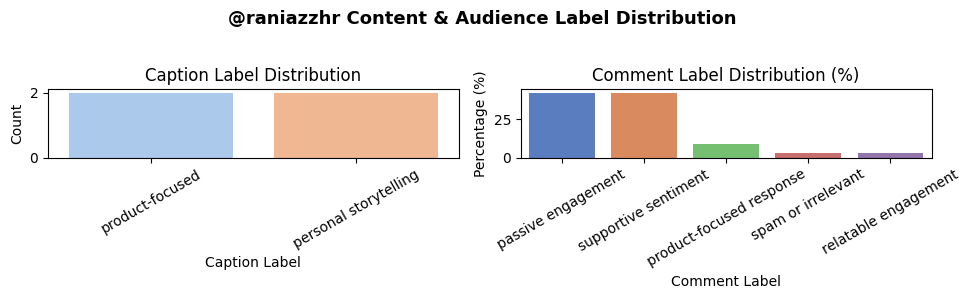

   🔁 Conversion Potential for @raniazzhr
   
   💬 Comment Quality
   Total 33 komentar dianalisis.
   42.4% passive engagement
   42.4% supportive sentiment
   9.1% product-focused response
   3.0% spam or irrelevant
   3.0% relatable engagement
   🎯 High-Value Comment Rate: 12.1%
   ⚠️ Low engagement quality - mostly passive comments
   
   💬 Komentar Berkualitas Tinggi yang Mewakili Audiens
   
   🔹 Relatable Engagement
   Contoh:
   "YAALLAH MIRIP BRAND SEBELAH TP GA KALAH KEREN"
   
   🔹 Product-Focused Response
   Contoh:
   "kak prefer nyc atau boston?"
   
   📢 Caption Behavior Summary – Influencer: raniazzhr
   
   🔁 Call-to-Action Habit:
   0 dari 4 caption mengandung CTA.
   
   🛍️ Product Mention:
   2 caption menyebut produk atau brand.
   Contoh:
   "matcha run & metro rides through soho🍵🧸 top @shopatvelvet pants @dumaofficial bag @nunine.official shoes @cueren_officia..."
   
   🎭 Tone of Voice:
   Dominan: product-focused.
   Contoh:
   "matcha run & metro rides through 

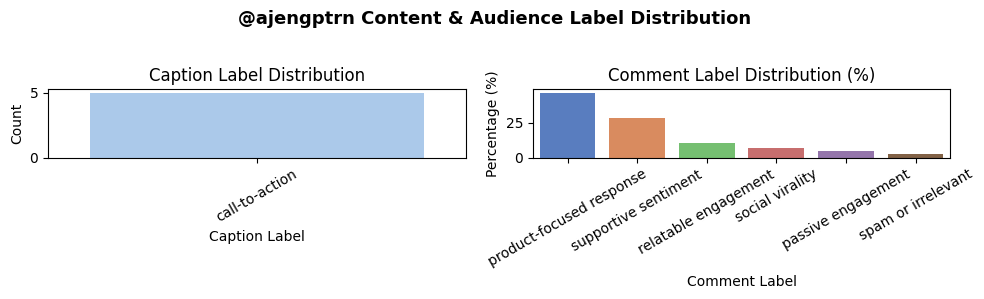

   🔁 Conversion Potential for @ajengptrn
   
   💬 Comment Quality
   Total 142 komentar dianalisis.
   46.5% product-focused response
   28.2% supportive sentiment
   10.6% relatable engagement
   7.0% social virality
   4.9% passive engagement
   2.8% spam or irrelevant
   🎯 High-Value Comment Rate: 64.1%
   
   💬 Komentar Berkualitas Tinggi yang Mewakili Audiens
   
   🔹 Relatable Engagement
   Contoh:
   "kak, kamu udah keliatan cooltone di awal reels 😭"
   
   🔹 Product-Focused Response
   Contoh:
   "Habis berapa kak?"
   
   🔹 Social Virality
   Contoh:
   "@iamevd coba ajh dl"
   
   📢 Caption Behavior Summary – Influencer: ajengptrn
   
   🔁 Call-to-Action Habit:
   5 dari 5 caption mengandung CTA.
   Contoh:
   "NGAPAIN PERSONAL COLOR? 💸 Aku juga punya pikiran kaya gitu kok, tapi emang kalian gak penasaran tuh shades foundation ka..."
   
   🎭 Tone of Voice:
   Dominan: call-to-action.
   Contoh:
   "NGAPAIN PERSONAL COLOR? 💸 Aku juga punya pikiran kaya gitu kok, tapi emang ka

In [7]:
# Menggunakan JSON brief input dengan sistem rekomendasi

custom_priorities = {
    'persona_fit': 0.15,        # Sedikit lebih tinggi untuk beauty brand
    'audience_fit': 0.45,       # Tetap prioritas utama
    'performance_pred': 0.30,   # Prediksi performa penting
    'budget_efficiency': 0.10   # Budget efficiency sebagai pertimbangan
}


try:
    result = process_json_brief_input(
        json_brief_input=sample_json_brief,
        influencers_df=df_instagram_influencers,
        caption_df=df_labeled_caption,
        comment_df=df_labeled_comment,
        bio_df=df_bio,
        brief_priorities=custom_priorities
    )

except Exception as e:
    print(f"\n❌ ERROR: {str(e)}")
    print(f"📝 Please check the input format and data availability")

# Tambahan fitur

## Setup

In [8]:
!pip install pulp
import pandas as pd
import numpy as np
import cvxpy as cp
from sentence_transformers import SentenceTransformer, util
from scipy.optimize import linprog
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpInteger, LpBinary
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import json
warnings.filterwarnings('ignore')

In [9]:
# Data

df_instagram_influencers = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/instagram_influencers_final.csv")
df_labeled_caption = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/labeled_caption.csv")
df_labeled_comment = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/labeled_comment.csv")
df_bio = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/bio.csv")
df_captions = pd.read_csv("https://raw.githubusercontent.com/AzrilFahmiardi/yujiem-rookie-datathon-2025/refs/heads/master/input/captions.csv")

## Scoring

In [10]:
# Kelas untuk optimasi pemilihan influencer berdasarkan budget dan estimasi impact
class BudgetOptimizer:
    def __init__(self):
        pass

    def filter_and_optimize(self, brief_budget, influencers_df, output_requirement=None):
        """
        Filter influencers by budget + find optimal content mix

        Parameters:
        - brief_budget: int - budget dari brief
        - influencers_df: DataFrame - data influencer
        - output_requirement: dict - requirement konten dari brief, misal: {'story': 2, 'feeds': 1, 'reels': 0}
        """
        filtered_influencers = []

        for _, infl in influencers_df.iterrows():
            if (brief_budget >= infl['rate_card_story'] or
                brief_budget >= infl['rate_card_feeds'] or
                brief_budget >= infl['rate_card_reels']):

                # Extract output requirements jika ada
                story_req = output_requirement.get('story', None) if output_requirement else None
                feeds_req = output_requirement.get('feeds', None) if output_requirement else None
                reels_req = output_requirement.get('reels', None) if output_requirement else None

                optimal_mix = self.optimize_content_mix(
                    budget=brief_budget,
                    story_rate=infl['rate_card_story'],
                    feeds_rate=infl['rate_card_feeds'],
                    reels_rate=infl['rate_card_reels'],
                    story_impact=self.estimate_story_impact(infl),
                    feeds_impact=self.estimate_feeds_impact(infl),
                    reels_impact=self.estimate_reels_impact(infl),
                    story_count_req=story_req,
                    feeds_count_req=feeds_req,
                    reels_count_req=reels_req
                )

                infl_dict = infl.to_dict()
                infl_dict.update({
                    'optimal_content_mix': optimal_mix,
                    'budget_efficiency': optimal_mix['total_impact'] / optimal_mix['total_cost'] if optimal_mix['total_cost'] > 0 else 0
                })
                filtered_influencers.append(infl_dict)

        return pd.DataFrame(filtered_influencers)

    def optimize_content_mix(self, budget, story_rate, feeds_rate, reels_rate, story_impact, feeds_impact, reels_impact,
                           story_count_req=None, feeds_count_req=None, reels_count_req=None):
        """
        Optimize content mix with optional fixed content requirements

        Parameters:
        - budget: int - available budget
        - *_rate: float - rate per content type
        - *_impact: float - impact score per content type
        - *_count_req: int/None - required count for content type (None = optimize, int = fixed)
        """
        prob = LpProblem("OptimalContentMix", LpMaximize)

        # Define variables with constraints
        if story_count_req is not None:
            # Fixed requirement
            x = LpVariable("story_count", story_count_req, story_count_req, cat=LpInteger)
            use_story = LpVariable("use_story", 1, 1, LpBinary) if story_count_req > 0 else LpVariable("use_story", 0, 0, LpBinary)
        else:
            # Optimize
            x = LpVariable("story_count", 0, 5, cat=LpInteger)
            use_story = LpVariable("use_story", 0, 1, LpBinary)

        if feeds_count_req is not None:
            # Fixed requirement
            y = LpVariable("feeds_count", feeds_count_req, feeds_count_req, cat=LpInteger)
            use_feeds = LpVariable("use_feeds", 1, 1, LpBinary) if feeds_count_req > 0 else LpVariable("use_feeds", 0, 0, LpBinary)
        else:
            # Optimize
            y = LpVariable("feeds_count", 0, 4, cat=LpInteger)
            use_feeds = LpVariable("use_feeds", 0, 1, LpBinary)

        if reels_count_req is not None:
            # Fixed requirement
            z = LpVariable("reels_count", reels_count_req, reels_count_req, cat=LpInteger)
            use_reels = LpVariable("use_reels", 1, 1, LpBinary) if reels_count_req > 0 else LpVariable("use_reels", 0, 0, LpBinary)
        else:
            # Optimize
            z = LpVariable("reels_count", 0, 3, cat=LpInteger)
            use_reels = LpVariable("use_reels", 0, 1, LpBinary)

        # Budget constraint
        prob += story_rate * x + feeds_rate * y + reels_rate * z <= budget

        # Binary constraints (only if optimizing)
        if story_count_req is None:
            prob += x >= 1 * use_story
            prob += x <= 1000 * use_story

        if feeds_count_req is None:
            prob += y >= 1 * use_feeds
            prob += y <= 1000 * use_feeds

        if reels_count_req is None:
            prob += z >= 1 * use_reels
            prob += z <= 1000 * use_reels

        # Objective function
        diversity_bonus = 5 * (use_story + use_feeds + use_reels)
        prob += story_impact * x + feeds_impact * y + reels_impact * z + diversity_bonus

        prob.solve()

        story_count = int(x.varValue) if x.varValue is not None else 0
        feeds_count = int(y.varValue) if y.varValue is not None else 0
        reels_count = int(z.varValue) if z.varValue is not None else 0
        total_cost = story_count * story_rate + feeds_count * feeds_rate + reels_count * reels_rate
        total_impact = story_count * story_impact + feeds_count * feeds_impact + reels_count * reels_impact
        remaining_budget = budget - total_cost

        return {
            'story_count': story_count,
            'feeds_count': feeds_count,
            'reels_count': reels_count,
            'total_cost': total_cost,
            'total_impact': total_impact,
            'remaining_budget': remaining_budget,
            'is_requirement_based': any([story_count_req is not None, feeds_count_req is not None, reels_count_req is not None])
        }

    def estimate_story_impact(self, influencer):
        """Estimate impact score for Instagram Story"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        tier_multiplier = {
            'Nano': 1.2, 'Micro': 1.1, 'Mid': 1.0, 'Macro': 0.9, 'Mega': 0.8
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * 0.7

    def estimate_feeds_impact(self, influencer):
        """Estimate impact score for Instagram Feeds"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        tier_multiplier = {
            'Nano': 1.2, 'Micro': 1.1, 'Mid': 1.0, 'Macro': 0.9, 'Mega': 0.8
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * 1.0

    def estimate_reels_impact(self, influencer):
        """Estimate impact score for Instagram Reels"""
        base_impact = influencer.get('engagement_rate_pct', 0.02) * 100
        viral_bonus = 1.5 if influencer.get('trending_status', False) else 1.2
        tier_multiplier = {
            'Nano': 1.3, 'Micro': 1.2, 'Mid': 1.1, 'Macro': 1.0, 'Mega': 0.9
        }.get(influencer.get('tier_followers', 'Micro'), 1.0)
        return base_impact * tier_multiplier * viral_bonus

    def parse_output_requirement_from_brief(self, output_json):
        """
        Parse output requirement dari JSON brief format

        Parameters:
        - output_json: dict - output section dari brief JSON

        Returns:
        - dict: requirement dalam format {'story': int, 'feeds': int, 'reels': int}
        """
        if not output_json:
            return None

        content_types = output_json.get('content_types', [])
        total_deliverables = output_json.get('deliverables', 0)

        # Default distribution jika tidak ada spesifikasi detail
        requirement = {'story': 0, 'feeds': 0, 'reels': 0}

        if content_types and total_deliverables > 0:
            # Distribusi merata berdasarkan content types yang dipilih
            per_type = total_deliverables // len(content_types)
            remainder = total_deliverables % len(content_types)

            for i, content_type in enumerate(content_types):
                content_key = content_type.lower()
                if content_key in requirement:
                    requirement[content_key] = per_type
                    if i < remainder:  # Sisa bagi rata ke type pertama
                        requirement[content_key] += 1

        return requirement if any(requirement.values()) else None

# Kelas untuk menghitung kecocokan persona brief dan influencer secara semantic (NLP)
class PersonaSemanticMatcher:
    def __init__(self, model_name='paraphrase-multilingual-MiniLM-L12-v2'):
        self.model = SentenceTransformer(model_name)

    def prepare_influencer_texts(self, bio_df, caption_df, max_posts=5):
        """
        Prepare influencer texts dari bio dan captions untuk similarity calculation
        """
        influencer_texts = {}
        grouped_captions = caption_df.groupby('instagram_account')

        for _, row in bio_df.iterrows():
            account = row['instagram_account']
            bio = str(row['bio']) if pd.notna(row['bio']) else ""

            captions = []
            if account in grouped_captions.groups:
                captions_raw = grouped_captions.get_group(account)['post_caption'].head(max_posts)
                captions = [str(c) for c in captions_raw if pd.notna(c)]

            full_text = bio + ' ' + ' '.join(captions)
            influencer_texts[account] = full_text.strip()

        return influencer_texts

    def calculate_similarity_scores(self, brief_persona_text, influencer_texts):
        """
        Hitung cosine similarity antara brief persona dan teks masing-masing influencer.
        """
        scores = {}
        brief_vec = self.model.encode(brief_persona_text)

        accounts = list(influencer_texts.keys())
        texts = list(influencer_texts.values())

        infl_vecs = self.model.encode(texts, show_progress_bar=False)
        cosine_scores = cosine_similarity([brief_vec], infl_vecs)[0]
        scores = dict(zip(accounts, cosine_scores))

        return scores

    def get_scored_df(self, brief_persona_text, bio_df, caption_df):
        """
        Mengembalikan DataFrame berisi akun influencer dan skor kecocokan persona.
        """
        influencer_texts = self.prepare_influencer_texts(bio_df, caption_df)
        scores = self.calculate_similarity_scores(brief_persona_text, influencer_texts)
        return pd.DataFrame([
            {'instagram_account': account, 'persona_fit_score': score}
            for account, score in scores.items()
        ])

# Kelas untuk audience matching menggunakan JSON-based approach dengan flexible weighting
class AudienceMatchingGNN:
    def __init__(self, default_weights=None):
        """
        Initialize audience matcher dengan flexible weight system
        """
        self.default_weights = default_weights or {
            "location": 0.4,
            "age": 0.3,
            "gender": 0.3
        }

        # Predefined weight strategies untuk different business scenarios
        self.weight_strategies = {
            "balanced": {"location": 0.33, "age": 0.33, "gender": 0.34},
            "location_focused": {"location": 0.6, "age": 0.25, "gender": 0.15},
            "demographic_focused": {"location": 0.2, "age": 0.4, "gender": 0.4},
            "age_priority": {"location": 0.2, "age": 0.6, "gender": 0.2},
            "gender_priority": {"location": 0.15, "age": 0.25, "gender": 0.6},
            "geo_only": {"location": 1.0, "age": 0.0, "gender": 0.0},
            "demo_only": {"location": 0.0, "age": 0.5, "gender": 0.5}
        }

    def get_weight_strategy(self, strategy_name):
        """Get predefined weight strategy"""
        return self.weight_strategies.get(strategy_name, self.default_weights)

    def calculate_audience_match_score(self, brief_audience, influencer_audience, weights=None, strategy=None):
        """
        Calculate audience match score dengan real Instagram insights data
        """
        # Priority: custom weights > strategy > default
        if weights is not None:
            used_weights = weights
        elif strategy is not None:
            used_weights = self.get_weight_strategy(strategy)
        else:
            used_weights = self.default_weights

        # Normalize weights
        total_weight = sum(used_weights.values())
        if abs(total_weight - 1.0) > 0.01:
            used_weights = {k: v/total_weight for k, v in used_weights.items()}

        # Calculate component scores
        location_score = self._calculate_location_score(brief_audience, influencer_audience)
        age_score = self._calculate_age_score(brief_audience, influencer_audience)
        gender_score = self._calculate_gender_score(brief_audience, influencer_audience)

        # Weighted total
        total_score = (
            location_score * used_weights["location"] +
            age_score * used_weights["age"] +
            gender_score * used_weights["gender"]
        )

        return {
            "location_score": round(location_score, 3),
            "age_score": round(age_score, 3),
            "gender_score": round(gender_score, 3),
            "total_score": round(total_score, 3),
            "weights_used": used_weights,
            "strategy_used": strategy or "custom"
        }

    def _calculate_location_score(self, brief, influencer):
        """Calculate location overlap score using REAL Instagram insights"""
        if "top_locations" not in brief or "top_locations" not in influencer:
            return 0.0

        brief_countries = set(brief["top_locations"].get("countries", []))
        brief_cities = set(brief["top_locations"].get("cities", []))

        country_score = sum(
            loc["percent"] for loc in influencer["top_locations"].get("countries", [])
            if loc["country"] in brief_countries
        )
        city_score = sum(
            loc["percent"] for loc in influencer["top_locations"].get("cities", [])
            if loc["city"] in brief_cities
        )

        return (country_score + city_score) / 200

    def _calculate_age_score(self, brief, influencer):
        """Calculate age overlap score using REAL Instagram insights"""
        if "age_range" not in brief or "age_range_overall" not in influencer:
            return 0.0

        brief_age = set(brief["age_range"])
        return sum(
            a["percent"] for a in influencer["age_range_overall"]
            if a["range"] in brief_age
        ) / 100

    def _calculate_gender_score(self, brief, influencer):
        """Calculate gender overlap score using REAL Instagram insights"""
        if "gender" not in brief or "gender_overall" not in influencer:
            return 0.0

        brief_gender = set(brief["gender"])
        return sum(
            g["percent"] for g in influencer["gender_overall"]
            if g["gender"] in brief_gender
        ) / 100

    def calculate_demographic_similarity(self, brief_data, influencer_data):
        """
        Backward compatibility dengan format lama - akan menggunakan extract functions
        """
        try:
            # Extract audience data using real data functions
            if 'audience_preference' in brief_data:
                brief_audience = json.loads(brief_data['audience_preference'])
            else:
                # Fallback for old format
                brief_audience = {
                    "top_locations": {"countries": ["Indonesia"], "cities": ["Jakarta"]},
                    "age_range": ["18-24", "25-34"],
                    "gender": ["Female", "Male"]
                }

            if 'audience_analytics' in influencer_data:
                infl_audience = json.loads(influencer_data['audience_analytics'])
            else:
                # Fallback for old format
                infl_audience = {
                    "top_locations": {"countries": [{"country": "Indonesia", "percent": 80}], "cities": []},
                    "age_range_overall": [{"range": "18-24", "percent": 50}],
                    "gender_overall": [{"gender": "Female", "percent": 60}]
                }

            result = self.calculate_audience_match_score(brief_audience, infl_audience, strategy="balanced")
            return result["total_score"]

        except Exception as e:
            print(f"Error in demographic similarity: {e}")
            return 0.5  # Default score if error

# Kelas untuk prediksi performa campaign influencer secara heuristik
class SocialMediaPerformancePredictor:
    def __init__(self):
        self.tier_benchmarks = {
            'Nano': {'engagement': 0.04, 'views': 5000},
            'Micro': {'engagement': 0.02, 'views': 25000},
            'Mid': {'engagement': 0.015, 'views': 75000},
            'Macro': {'engagement': 0.012, 'views': 200000},
            'Mega': {'engagement': 0.01, 'views': 500000}
        }

    def predict_campaign_performance(self, influencer_data, brief_data):
        """Predict campaign performance using heuristic approach"""
        # Calculate performance components
        engagement_score = self.calculate_engagement_score(influencer_data)
        authenticity_score = self.calculate_authenticity_score(influencer_data)
        reach_potential = self.calculate_reach_potential(influencer_data)
        brief_fit = self.calculate_brief_fit(influencer_data, brief_data)

        # Combined performance score
        performance_score = (
            engagement_score * 0.3 +
            authenticity_score * 0.25 +
            reach_potential * 0.25 +
            brief_fit * 0.2
        )

        return {
            'performance_score': min(performance_score, 1.0),
            'engagement_score': engagement_score,
            'authenticity_score': authenticity_score,
            'reach_potential': reach_potential,
            'brief_fit': brief_fit
        }

    def calculate_engagement_score(self, influencer_data):
        """Calculate engagement quality score"""
        er = influencer_data.get('engagement_rate_pct', 0)
        tier = influencer_data.get('tier_followers', 'Micro')
        benchmark = self.tier_benchmarks.get(tier, {'engagement': 0.02})['engagement']

        normalized_er = min(er / benchmark, 2.0) if benchmark > 0 else 0
        return normalized_er / 2.0

    def calculate_authenticity_score(self, influencer_data):
        """Calculate authenticity based on endorse rate and consistency"""
        endorse_rate = influencer_data.get('random_endorse_rate', 0.5)
        consistency = influencer_data.get('behavior_consistency', False)

        authenticity = (1 - endorse_rate) * 0.7
        if consistency:
            authenticity += 0.3

        return min(authenticity, 1.0)

    def calculate_reach_potential(self, influencer_data):
        """Calculate reach potential based on views and virality"""
        avg_views = influencer_data.get('avg_reels_views', 0)
        trending = influencer_data.get('trending_status', False)
        tier = influencer_data.get('tier_followers', 'Micro')

        benchmark = self.tier_benchmarks.get(tier, {'views': 25000})['views']
        view_score = min(avg_views / benchmark, 2.0) / 2.0 if benchmark > 0 else 0

        if trending:
            view_score *= 1.2

        return min(view_score, 1.0)

    def calculate_brief_fit(self, influencer_data, brief_data):
        """Calculate brief-influencer fit score"""
        industry_match = 0.5
        if influencer_data.get('expertise_field', '').lower() in brief_data.get('industry', '').lower():
            industry_match = 0.8

        tier = influencer_data.get('tier_followers', 'Micro')
        budget = brief_data.get('budget', 0)

        # Budget appropriateness
        if tier == 'Nano' and budget < 50000000:
            budget_fit = 0.9
        elif tier == 'Micro' and 20000000 <= budget <= 200000000:
            budget_fit = 0.8
        elif tier == 'Mid' and 100000000 <= budget <= 500000000:
            budget_fit = 0.8
        else:
            budget_fit = 0.6

        return (industry_match + budget_fit) / 2

# Kelas untuk ranking akhir dengan multiple objective
class MultiObjectiveRanker:
    def __init__(self):
        pass

    def rank_influencers(self, scored_influencers, priorities):
        """Rank influencers berdasarkan weighted multiple objectives"""
        ranked_results = []

        for influencer in scored_influencers:
            final_score = 0
            for criterion, weight in priorities.items():
                score = influencer.get(criterion, 0)
                final_score += score * weight

            result = influencer.copy()
            result['final_score'] = final_score
            ranked_results.append(result)

        # Sort by final score descending
        ranked_results.sort(key=lambda x: x['final_score'], reverse=True)
        return ranked_results

# Main SOTAInfluencerMatcher Class
class SOTAInfluencerMatcher:
    def __init__(self):
        """Initialize dengan semua komponen yang sudah ditest"""
        self.budget_optimizer = BudgetOptimizer()
        self.persona_matcher = PersonaSemanticMatcher()
        self.audience_matcher = AudienceMatchingGNN()
        self.performance_predictor = SocialMediaPerformancePredictor()
        self.final_ranker = MultiObjectiveRanker()

    def extract_brief_audience_preference(self, brief_row):
        """Extract audience preference dari brief data - REAL FORMAT"""
        try:
            audience_pref_str = brief_row['audience_preference']
            audience_pref = json.loads(audience_pref_str)
            return audience_pref
        except Exception as e:
            return {
                "top_locations": {"countries": ["Indonesia"], "cities": ["Jakarta"]},
                "age_range": ["18-24", "25-34"],
                "gender": ["Female", "Male"]
            }

    def extract_influencer_audience_analytics(self, influencer_row):
        """Extract audience analytics dari influencer data - REAL Instagram Insights"""
        try:
            audience_analytics_str = influencer_row['audience_analytics']
            audience_analytics = json.loads(audience_analytics_str)
            return audience_analytics
        except Exception as e:
            return {
                "top_locations": {"countries": [], "cities": []},
                "age_range_overall": [],
                "gender_overall": []
            }

## Main function

In [11]:
# MAIN FUNCTIONS

def get_top_influencers_for_brief(brief_id, briefs_df, influencers_df, bio_df, caption_df, top_n=5, brief_priorities=None, adaptive_weights=None):
    """
    UPDATED: Get top influencers untuk brief dengan real data integration + output requirements + adaptive weights

    Parameters:
    - brief_id: str - ID brief
    - briefs_df: DataFrame - data brief
    - influencers_df: DataFrame - data influencer
    - bio_df: DataFrame - data bio
    - caption_df: DataFrame - data caption
    - top_n: int - jumlah rekomendasi
    - brief_priorities: dict - prioritas scoring (akan di-override oleh adaptive_weights jika ada)
    - adaptive_weights: dict - bobot adaptive dari adaptive weight calculator
    """
    # Priority: adaptive_weights > brief_priorities > default
    if adaptive_weights is not None:
        final_priorities = adaptive_weights
        print(f"🔧 Using Adaptive Weight Strategy")
    elif brief_priorities is not None:
        final_priorities = brief_priorities
        print(f"📊 Using Custom Priority Strategy")
    else:
        final_priorities = {
            'persona_fit': 0.25,
            'audience_fit': 0.25,
            'performance_pred': 0.25,
            'budget_efficiency': 0.25
        }
        print(f"⚖️ Using Default Equal Weight Strategy")

    # Initialize matcher dengan improved components
    matcher = SOTAInfluencerMatcher()

    # Get brief data
    brief_data = briefs_df[briefs_df['brief_id'] == brief_id]
    if brief_data.empty:
        print(f"Brief '{brief_id}' tidak ditemukan")
        return []

    brief_row = brief_data.iloc[0]

    try:
        # Parse output requirement dari brief
        output_requirement = None
        if 'output' in brief_row and pd.notna(brief_row['output']):
            try:
                output_json = json.loads(brief_row['output'])
                output_requirement = matcher.budget_optimizer.parse_output_requirement_from_brief(output_json)
                if output_requirement:
                    print(f"📋 Output Requirements: {output_requirement}")
            except Exception as e:
                print(f"⚠️ Warning: Could not parse output requirement: {e}")

        # Step 1: Budget filtering dengan output requirement
        affordable_influencers = matcher.budget_optimizer.filter_and_optimize(
            brief_row['budget'], influencers_df, output_requirement
        )

        if affordable_influencers.empty:
            print(f"Tidak ada influencer yang affordable untuk budget Rp {brief_row['budget']:,}")
            return []

        # Step 2: Persona matching
        persona_scores_df = matcher.persona_matcher.get_scored_df(
            brief_persona_text=brief_row['influencer_persona'],
            bio_df=bio_df,
            caption_df=caption_df
        )

        # Merge persona scores
        affordable_influencers = pd.merge(
            affordable_influencers,
            persona_scores_df.rename(columns={'persona_fit_score': 'persona_fit'}),
            left_on='username_instagram',
            right_on='instagram_account',
            how='left'
        )
        affordable_influencers['persona_fit'] = affordable_influencers['persona_fit'].fillna(0.5)

        # Step 3: Audience matching menggunakan REAL data
        brief_audience = matcher.extract_brief_audience_preference(brief_row)

        scored_influencers = []
        for _, infl in affordable_influencers.iterrows():
            # Extract real audience analytics
            infl_audience = matcher.extract_influencer_audience_analytics(infl)

            # Calculate audience match menggunakan AudienceMatchingGNN
            audience_result = matcher.audience_matcher.calculate_audience_match_score(
                brief_audience, infl_audience, strategy="balanced"
            )

            # Performance prediction
            performance_result = matcher.performance_predictor.predict_campaign_performance(
                infl.to_dict(), brief_row.to_dict()
            )

            scored_influencers.append({
                'influencer': infl['username_instagram'],
                'persona_fit': infl.get('persona_fit', 0.5),
                'audience_fit': audience_result['total_score'],  # Real audience matching
                'performance_pred': performance_result['performance_score'],
                'budget_efficiency': infl['budget_efficiency'],
                'tier': infl['tier_followers'],
                'expertise': infl['expertise_field'],
                # Additional fields untuk format InfluencerMatcher
                'engagement_rate': infl.get('engagement_rate_pct', 0),
                'authenticity_score': performance_result.get('authenticity_score', 0),
                'reach_potential': performance_result.get('reach_potential', 0),
                'brand_fit': performance_result.get('brand_fit', 0),
                'optimal_content_mix': infl.get('optimal_content_mix', {}),
                'raw_influencer_data': infl.to_dict()
            })

        # Step 4: Final ranking dengan adaptive/custom weights
        ranked_results = matcher.final_ranker.rank_influencers(scored_influencers, final_priorities)

        return ranked_results[:top_n]

    except Exception as e:
        print(f"❌ Error in get_top_influencers_for_brief: {e}")
        import traceback
        traceback.print_exc()
        return []

def generate_brief_summary(briefs_df, brief_id):
    """Generate brief summary dengan informasi lengkap termasuk output requirements"""
    brief_data = briefs_df[briefs_df['brief_id'] == brief_id]
    if brief_data.empty:
        return f"Brief '{brief_id}' tidak ditemukan"

    brief = brief_data.iloc[0]

    # Format budget
    budget_str = f"Rp {brief['budget']:,}"

    # Extract audience preference
    try:
        audience_pref = json.loads(brief['audience_preference'])
        target_countries = ", ".join(audience_pref['top_locations']['countries'][:3])
        target_cities = ", ".join(audience_pref['top_locations']['cities'][:3])
        target_age = ", ".join(audience_pref['age_range'])
        target_gender = ", ".join(audience_pref['gender'])
    except:
        target_countries = "Indonesia"
        target_cities = "Jakarta"
        target_age = "18-34"
        target_gender = "All"

    # Extract output requirements
    output_info = ""
    try:
        if 'output' in brief and pd.notna(brief['output']):
            output_json = json.loads(brief['output'])
            content_types = output_json.get('content_types', [])
            deliverables = output_json.get('deliverables', 0)
            output_info = f"\n🎬 Content Requirements: {', '.join(content_types)} ({deliverables} total deliverables)"
    except:
        pass

    summary = f"""
{brief['product_name']}

🏢 Industry: {brief['industry']}
💰 Budget: {budget_str}
🎯 Target Audience:
   📍 Countries: {target_countries}
   🏙️ Cities: {target_cities}
   👥 Age Range: {target_age}
   ⚧ Gender: {target_gender}{output_info}
📝 Influencer Persona: {brief['influencer_persona'][:150]}...
"""
    return summary

def generate_influencer_insight(username, caption_df, comment_df, show_plot=False):
    """
    Generate detailed insight untuk influencer berdasarkan caption dan comment
    Format output sama seperti InfluencerMatcher.ipynb
    """
    result = f"🔁 Conversion Potential for @{username}\n"

    captions = caption_df[caption_df["instagram_account"] == username]
    comments = comment_df[comment_df["instagram_account"] == username]

    # --- Comment Insight ---
    comment_counts = None
    if not comments.empty:
        comment_counts = comments["predicted_label"].value_counts(normalize=True).mul(100).round(1)
        total_comments = len(comments)
        result += f"\n💬 Comment Quality\nTotal {total_comments} komentar dianalisis.\n"

        # Narasi persentase tiap label
        for label, pct in comment_counts.items():
            label_id = label.lower().replace("_", " ")
            result += f"{pct:.1f}% {label_id}\n"

        # High-value comment rate
        high_value_labels = ["relatable engagement", "product-focused response", "social virality"]
        high_value_pct = sum([comment_counts.get(lbl, 0) for lbl in comment_counts.index if lbl.lower() in high_value_labels])
        result += f"🎯 High-Value Comment Rate: {high_value_pct:.1f}%\n"
        if high_value_pct < 20:
            result += "Cukup rendah, mengindikasikan bahwa interaksi dari audiens masih dominan pujian atau pasif.\n"

        result += "\n💬 Komentar Berkualitas Tinggi yang Mewakili Audiens\n"
        for label in high_value_labels:
            label_comments = comments[comments["predicted_label"].str.lower() == label]
            if not label_comments.empty:
                result += f"\n🔹 {label.title()}\n"
                example = label_comments["comment"].iloc[0]
                result += f'Contoh:\n"{example}"\n'

        if total_comments < 20:
            result += f"\n⚠️ Hanya {total_comments} komentar terdeteksi. Insight ini mungkin kurang representatif karena volume interaksi yang rendah.\n"
    else:
        result += "\nTidak ada komentar yang dapat dianalisis.\n"

    # --- Caption Insight ---
    result += f"\n📢 Caption Behavior Summary – Influencer: {username}\n"
    caption_counts = None
    if not captions.empty:
        # Call-to-action habit
        cta_labels = ["call-to-action", "engagement-inviting"]
        cta_count = captions["predicted_label"].str.lower().isin(cta_labels).sum()
        total_captions = len(captions)
        result += f"\n🔁 Call-to-Action Habit:\n{cta_count} dari {total_captions} caption mengandung CTA.\n"
        if cta_count > 0:
            example_cta = captions[captions["predicted_label"].str.lower().isin(cta_labels)]["post_caption"].iloc[0]
            result += f'Contoh:\n"{example_cta[:120]}..."\n'

        # Tone of voice
        caption_counts = captions["predicted_label"].value_counts()
        dominant_label = caption_counts.idxmax()
        result += f"\n🎭 Tone of Voice:\nDominan: {dominant_label}.\n"
        example_tone = captions[captions["predicted_label"] == dominant_label]["post_caption"].iloc[0]
        result += f'Contoh:\n"{example_tone[:120]}..."\n'

        # Engagement style
        engagement_count = captions["predicted_label"].str.lower().isin(["engagement-inviting"]).sum()
        if engagement_count > 0:
            result += f"\n💬 Engagement Style:\n{engagement_count} caption mengandung ajakan interaksi.\n"

        result += f"\n📊 Distribusi label utama:\n"
        for lbl, cnt in caption_counts.items():
            result += f"{lbl}: {cnt}\n"

        if cta_count > 0:
            result += "Juga ditemukan upaya interaksi dua arah dengan audiens.\n"
    else:
        result += "\nTidak ada caption yang dapat dianalisis.\n"

    # Add plot functionality
    if show_plot and (caption_counts is not None or comment_counts is not None):
        import matplotlib.pyplot as plt
        import seaborn as sns

        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        if caption_counts is not None:
            sns.barplot(x=caption_counts.index, y=caption_counts.values, palette="pastel", ax=axes[0])
            axes[0].set_title("Caption Label Distribution")
            axes[0].set_ylabel("Count")
            axes[0].set_xlabel("Caption Label")
            axes[0].tick_params(axis='x', rotation=30)
        else:
            axes[0].axis('off')
            axes[0].set_title("No Caption Data")

        if comment_counts is not None:
            sns.barplot(x=comment_counts.index, y=comment_counts.values, palette="muted", ax=axes[1])
            axes[1].set_title("Comment Label Distribution (%)")
            axes[1].set_ylabel("Percentage (%)")
            axes[1].set_xlabel("Comment Label")
            axes[1].tick_params(axis='x', rotation=30)
        else:
            axes[1].axis('off')
            axes[1].set_title("No Comment Data")

        plt.suptitle(f"@{username} Content & Audience Label Distribution", fontsize=13, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    return result.strip()

# MAIN DISPLAY FUNCTION

def display_brief_recommendation(brief_id, briefs_df, influencers_df, caption_df, comment_df, bio_df, top_n=3, brief_priorities=None, adaptive_weights=None):
    """
    UPDATED: Display brief summary and top influencer recommendations dengan real data + adaptive weights

    Parameters:
    - brief_id: str - ID brief
    - briefs_df: DataFrame - data brief
    - influencers_df: DataFrame - data influencer
    - caption_df: DataFrame - data caption
    - comment_df: DataFrame - data comment
    - bio_df: DataFrame - data bio
    - top_n: int - jumlah rekomendasi
    - brief_priorities: dict - prioritas scoring manual
    - adaptive_weights: dict - bobot adaptive (prioritas lebih tinggi dari brief_priorities)
    """
    print(f"\n{'='*80}")
    print(f"🎯 INFLUENCER RECOMMENDATION SYSTEM")
    if adaptive_weights:
        print(f"🧠 POWERED BY ADAPTIVE WEIGHT CALCULATOR")
    print(f"{'='*80}")

    # Get recommendations menggunakan updated system
    recommendations = get_top_influencers_for_brief(
        brief_id, briefs_df, influencers_df, bio_df, caption_df, top_n, brief_priorities, adaptive_weights
    )

    if not recommendations:
        print("❌ No recommendations found.")
        return

    # Display Brief Summary
    print(f"\n📊 BRIEF SUMMARY: {brief_id.upper()}")
    print(f"{'='*60}")
    print(generate_brief_summary(briefs_df, brief_id))

    print(f"\n🏆 TOP {top_n} INFLUENCER RECOMMENDATIONS:")
    print(f"{'='*60}")

    for i, rec in enumerate(recommendations, 1):
        tier_emoji = {
            "Nano": "🔥", "Micro": "⭐", "Mid": "🚀",
            "Macro": "💎", "Mega": "👑"
        }.get(rec['tier'], "📱")

        print(f"\n{i}. {tier_emoji} @{rec['influencer']} ({rec['tier']} Influencer)")
        print(f"   📊 Overall Match Score: {rec['final_score']:.1%}")

        # Add content insights with CHARTS ENABLED
        insight = generate_influencer_insight(
            username=rec['influencer'],
            caption_df=caption_df,
            comment_df=comment_df,
            show_plot=True
        )

        # Print insight dengan indentasi
        for line in insight.split("\n"):
            print(f"   {line}")

        print(f"\n   🎯 Score Breakdown:")
        print(f"      • Budget Efficiency:      {rec['budget_efficiency'] * 1_000_000:.2f} points/Million Rp")
        print(f"      • Persona Fit:           {rec['persona_fit']:.1%}")
        print(f"      • Audience Match:        {rec['audience_fit']:.1%}")
        print(f"      • Performance Potential: {rec['performance_pred']:.1%}")

        print(f"\n   📈 Performance Metrics:")
        print(f"      • Engagement Rate:       {rec.get('engagement_rate', 0):.2%}")
        print(f"      • Authenticity Score:    {rec.get('authenticity_score', 0):.1%}")
        print(f"      • Reach Potential:       {rec.get('reach_potential', 0):.1%}")
        print(f"      • Brand Alignment:       {rec.get('brand_fit', 0):.1%}")

        print(f"\n   💰 Optimal Campaign Strategy:")
        mix = rec.get('optimal_content_mix', {})
        strategy_type = "📋 Fixed Requirements" if mix.get('is_requirement_based', False) else "🎯 Optimized Mix"
        print(f"      {strategy_type}")
        if mix.get('story_count', 0) > 0:
            print(f"      • Instagram Stories: {mix['story_count']} posts")
        if mix.get('feeds_count', 0) > 0:
            print(f"      • Feed Posts: {mix['feeds_count']} posts")
        if mix.get('reels_count', 0) > 0:
            print(f"      • Reels: {mix['reels_count']} posts")

        print(f"\n   💳 Financial Summary:")
        print(f"      • Total Investment:      Rp {mix.get('total_cost', 0):,}")
        print(f"      • Budget Remaining:      Rp {mix.get('remaining_budget', 0):,}")
        print(f"      • Expected Impact:       {mix.get('total_impact', 0):.1f} points")

        # Key Insights section
        raw_data = rec.get('raw_influencer_data', {})
        insights = []
        if raw_data.get('trending_status', False):
            insights.append("🔥 Currently trending")
        if raw_data.get('behavior_consistency', False):
            insights.append("✅ Consistent content behavior")
        if raw_data.get('campaign_success_signif', False):
            insights.append("🎯 Proven campaign success")

        if insights:
            print(f"\n   💡 Key Insights:")
            for insight_text in insights:
                print(f"      • {insight_text}")

        if i < len(recommendations):
            print(f"\n{'-' * 80}")

    # Show strategy used
    final_weights = adaptive_weights or brief_priorities
    if final_weights:
        print(f"\n🎛️ Scoring Strategy Applied:")
        sorted_weights = sorted(final_weights.items(), key=lambda x: x[1], reverse=True)
        for component, weight in sorted_weights:
            print(f"   • {component.replace('_', ' ').title()}: {weight:.1%}")

    print(f"\n✅ RECOMMENDATION COMPLETE")
    if adaptive_weights:
        print(f"🧠 Enhanced with Adaptive Weight Intelligence")
    print(f"💡 Using Real Instagram Insights for Audience Matching")
    print(f"🚀 Powered by Enhanced Multi-Component Analysis")
    print(f"📊 With Visual Analytics for Each Influencer")

## Adaptive Weight

In [12]:
class SimpleAdaptiveWeightCalculator:
    def __init__(self):
        # Base weights - equal distribution
        self.base_weights = {
            'persona_fit': 0.25,
            'audience_fit': 0.25,
            'performance_pred': 0.25,
            'budget_efficiency': 0.25
        }

    def calculate_adaptive_weights(self, marketing_objective=None, target_goals=None,
                                 timing_campaign=None, esg_alignment=None,
                                 risk_tolerance=None, niche=None, location_prior=None):
        """
        Calculate adaptive weights based on KOL Brief structure

        Args matching KOL Brief structure:
            marketing_objective: List - ['Cognitive', 'Conative', 'Affective']
            target_goals: List - ['Awareness', 'Engagement', 'Conversions', etc.]
            timing_campaign: String/Date - Campaign timing
            esg_alignment: String - ESG text description
            risk_tolerance: String - ['High', 'Medium', 'Low']
            niche: List - ['Lifestyle', 'Beauty', 'Tech/Gadget', etc.]
            location_prior: String - Location description

        Returns:
            dict: Contains 'weights', 'applied_adjustments', 'total_adjustments'
        """

        # Start with base weights
        weights = self.base_weights.copy()
        applied_adjustments = []

        # 1. Marketing Objective Adjustments
        if marketing_objective:
            if isinstance(marketing_objective, str):
                marketing_objective = [marketing_objective]

            if 'Cognitive' in marketing_objective:
                # Awareness focus - boost persona and audience fit
                weights['persona_fit'] += 0.1
                weights['audience_fit'] += 0.1
                applied_adjustments.append("Cognitive focus: +persona_fit, +audience_fit")

            if 'Conative' in marketing_objective:
                # Action focus - boost performance prediction
                weights['performance_pred'] += 0.15
                applied_adjustments.append("Conative focus: +performance_pred")

            if 'Affective' in marketing_objective:
                # Emotional connection - boost persona fit
                weights['persona_fit'] += 0.1
                applied_adjustments.append("Affective focus: +persona_fit")

        # 2. Target Goals Adjustments
        if target_goals:
            if isinstance(target_goals, str):
                target_goals = [target_goals]

            conversion_goals = ['Conversions', 'Traffic', 'Leads Generation']
            awareness_goals = ['Awareness', 'Brand Recognition', 'Reach']
            engagement_goals = ['Engagement', 'Community Building', 'Content Amplification']

            if any(goal in target_goals for goal in conversion_goals):
                weights['performance_pred'] += 0.1
                applied_adjustments.append("Conversion goals: +performance_pred")

            if any(goal in target_goals for goal in awareness_goals):
                weights['audience_fit'] += 0.1
                applied_adjustments.append("Awareness goals: +audience_fit")

            if any(goal in target_goals for goal in engagement_goals):
                weights['persona_fit'] += 0.05
                weights['performance_pred'] += 0.05
                applied_adjustments.append("Engagement goals: +persona_fit, +performance_pred")

        # 3. Risk Tolerance Adjustments
        if risk_tolerance:
            if risk_tolerance.lower() == 'low':
                weights['budget_efficiency'] += 0.1
                weights['performance_pred'] += 0.05
                applied_adjustments.append("Low risk: +budget_efficiency, +performance_pred")
            elif risk_tolerance.lower() == 'high':
                weights['persona_fit'] += 0.1
                applied_adjustments.append("High risk: +persona_fit")

        # 4. Niche-based Adjustments
        if niche:
            if isinstance(niche, str):
                niche = [niche]

            performance_niches = ['Tech/Gadget', 'Sport']
            audience_niches = ['Lifestyle', 'Food', 'Entertainment']
            persona_niches = ['Beauty', 'Sustainability', 'Educator']

            if any(n in niche for n in performance_niches):
                weights['performance_pred'] += 0.05
                applied_adjustments.append("Performance niche: +performance_pred")

            if any(n in niche for n in audience_niches):
                weights['audience_fit'] += 0.05
                applied_adjustments.append("Audience niche: +audience_fit")

            if any(n in niche for n in persona_niches):
                weights['persona_fit'] += 0.05
                applied_adjustments.append("Persona niche: +persona_fit")

        # 5. ESG Alignment Adjustments
        if esg_alignment and len(str(esg_alignment).strip()) > 10:
            weights['persona_fit'] += 0.05
            applied_adjustments.append("ESG focus: +persona_fit")

        # 6. Location Prior Adjustments
        if location_prior and len(str(location_prior).strip()) > 5:
            weights['audience_fit'] += 0.05
            applied_adjustments.append("Location specific: +audience_fit")

        # 7. Timing Campaign Adjustments (seasonal/special events)
        if timing_campaign:
            timing_str = str(timing_campaign).lower()
            special_events = ['ramadan', 'lebaran', 'christmas', 'new year', 'valentine', 'independence']
            if any(event in timing_str for event in special_events):
                weights['audience_fit'] += 0.05
                applied_adjustments.append("Special timing: +audience_fit")

        # Normalize weights to sum to 1.0
        total_weight = sum(weights.values())
        if total_weight > 0:
            weights = {k: v/total_weight for k, v in weights.items()}

        return {
            'weights': weights,
            'applied_adjustments': applied_adjustments,
            'total_adjustments': len(applied_adjustments)
        }

# mengkonversi input JSON brief menjadi format yang sesuai dengan sistem

def process_json_brief_input(json_brief_input, influencers_df, caption_df, comment_df, bio_df,
                           brief_priorities=None, use_adaptive_weights=True):
    """
    Fungsi untuk memproses input JSON brief dan menjalankan rekomendasi influencer

    Parameters:
    - json_brief_input: dict - JSON input brief dari user
    - influencers_df: DataFrame - data influencer Instagram
    - caption_df: DataFrame - data caption terklasifikasi
    - comment_df: DataFrame - data comment terklasifikasi
    - bio_df: DataFrame - data bio influencer
    - brief_priorities: dict - prioritas komponen scoring (opsional, akan di-override jika use_adaptive_weights=True)
    - use_adaptive_weights: bool - gunakan adaptive weight calculator atau tidak

    Returns:
    - Menampilkan rekomendasi influencer dan mengembalikan hasil
    """

    # 1. Konversi JSON input menjadi DataFrame brief
    brief_df = convert_json_to_brief_dataframe(json_brief_input)

    # 2. Ekstrak brief_id dan top_n dari JSON
    brief_id = json_brief_input.get("brief_id")
    top_n = json_brief_input.get("total_influencer", 3)  # default 3 jika tidak ada

    # 3. Calculate adaptive weights jika diminta
    adaptive_weights = None
    if use_adaptive_weights:
        adaptive_calculator = SimpleAdaptiveWeightCalculator()

        # Extract data for adaptive calculation
        marketing_objective = json_brief_input.get('marketing_objective')
        target_goals = json_brief_input.get('target_goals')
        timing_campaign = json_brief_input.get('timing_campaign')
        esg_alignment = ', '.join(json_brief_input.get('esg_allignment', [])) if json_brief_input.get('esg_allignment') else None
        risk_tolerance = json_brief_input.get('risk_tolerance')
        niche = json_brief_input.get('niche')
        location_prior = ', '.join(json_brief_input.get('location_prior', [])) if json_brief_input.get('location_prior') else None

        adaptive_result = adaptive_calculator.calculate_adaptive_weights(
            marketing_objective=marketing_objective,
            target_goals=target_goals,
            timing_campaign=timing_campaign,
            esg_alignment=esg_alignment,
            risk_tolerance=risk_tolerance,
            niche=niche,
            location_prior=location_prior
        )

        adaptive_weights = adaptive_result['weights']

        print(f"🧠 ADAPTIVE WEIGHT CALCULATION")
        print(f"📊 Applied {adaptive_result['total_adjustments']} contextual adjustments:")
        for adj in adaptive_result['applied_adjustments']:
            print(f"   • {adj}")
        print(f"⚖️ Final Adaptive Weights:")
        for component, weight in sorted(adaptive_weights.items(), key=lambda x: x[1], reverse=True):
            print(f"   • {component.replace('_', ' ').title()}: {weight:.1%}")
        print(f"{'='*60}")

    # 4. Set default brief_priorities jika tidak ada adaptive weights dan tidak disediakan
    if not use_adaptive_weights and brief_priorities is None:
        brief_priorities = {
            'persona_fit': 0.1,
            'audience_fit': 0.45,
            'performance_pred': 0.35,
            'budget_efficiency': 0.1
        }

    # 5. Jalankan display_brief_recommendation dengan parameter yang sudah dikonversi
    return display_brief_recommendation(
        brief_id=brief_id,
        briefs_df=brief_df,
        influencers_df=influencers_df,
        caption_df=caption_df,
        comment_df=comment_df,
        bio_df=bio_df,
        top_n=top_n,
        brief_priorities=brief_priorities,
        adaptive_weights=adaptive_weights  # Pass adaptive weights
    )

def convert_json_to_brief_dataframe(json_brief):
    """
    Mengkonversi JSON brief menjadi DataFrame dengan format yang sesuai

    Parameters:
    - json_brief: dict - JSON input brief

    Returns:
    - DataFrame dengan satu baris berisi data brief
    """
    import json

    # Konversi list dan dict menjadi string JSON untuk kompatibilitas dengan DataFrame
    brief_data = {
        'brief_id': json_brief.get('brief_id'),
        'brand_name': json_brief.get('brand_name'),
        'industry': json_brief.get('industry'),
        'product_name': json_brief.get('product_name'),
        'overview': json_brief.get('overview'),
        'usp': json_brief.get('usp'),
        'marketing_objective': json.dumps(json_brief.get('marketing_objective', [])),  # Convert list to JSON string
        'target_goals': json.dumps(json_brief.get('target_goals', [])),  # Convert list to JSON string
        'timing_campaign': json_brief.get('timing_campaign'),
        'audience_preference': json.dumps(json_brief.get('audience_preference', {})),  # Convert dict to JSON string
        'influencer_persona': json_brief.get('influencer_persona'),
        'total_influencer': json_brief.get('total_influencer'),
        'niche': json.dumps(json_brief.get('niche', [])),  # Convert list to JSON string
        'location_prior': ', '.join(json_brief.get('location_prior', [])) if isinstance(json_brief.get('location_prior'), list) else json_brief.get('location_prior', ''),
        'esg_allignment': ', '.join(json_brief.get('esg_allignment', [])) if isinstance(json_brief.get('esg_allignment'), list) else json_brief.get('esg_allignment', ''),
        'budget': json_brief.get('budget'),
        'output': json.dumps(json_brief.get('output', {})),  # Convert dict to JSON string
        'risk_tolerance': json_brief.get('risk_tolerance')
    }

    # Buat DataFrame dengan satu baris
    brief_df = pd.DataFrame([brief_data])

    return brief_df

def validate_json_brief_input(json_brief):
    """
    Validasi input JSON brief untuk memastikan field wajib ada

    Parameters:
    - json_brief: dict - JSON input brief

    Returns:
    - tuple: (is_valid: bool, error_message: str)
    """
    required_fields = [
        'brief_id', 'brand_name', 'industry', 'product_name',
        'overview', 'influencer_persona', 'total_influencer',
        'budget'
    ]

    missing_fields = []
    for field in required_fields:
        if field not in json_brief or json_brief[field] is None:
            missing_fields.append(field)

    if missing_fields:
        return False, f"Missing required fields: {', '.join(missing_fields)}"

    return True, "Valid input"

## Example usage

In [13]:
# Contoh penggunaan dengan JSON input brief - NANTI KITA DAPETIN DARI FRONT END WEB

sample_json_brief = {
  "brief_id": "BRIEF_001",
  "brand_name": "Avoskin",
  "industry": "Skincare & Beauty",
  "product_name": "GlowSkin Vitamin C Serum",
  "overview": "Premium vitamin C serum untuk mencerahkan dan melindungi kulit dari radikal bebas",
  "usp": "Formula 20% Vitamin C dengan teknologi nano-encapsulation untuk penetrasi optimal",
  "marketing_objective": [
    "Cognitive",
    "Affective"
  ],
  "target_goals": [
    "Awareness",
    "Brand Perception",
    "Product Education"
  ],
  "timing_campaign": "2025-02-15",
  "audience_preference": {
    "top_locations": {
      "countries": [
        "Indonesia",
        "Malaysia",
        "Singapore"
      ],
      "cities": [
        "Jakarta",
        "Surabaya",
        "Bandung",
        "Kuala Lumpur"
      ]
    },
    "age_range": [
      "18-24",
      "25-34"
    ],
    "gender": [
      "Female"
    ]
  },
  "influencer_persona": "Beauty enthusiast, skincare expert, authentic product reviewer dengan focus pada natural skincare dan anti-aging",
  "total_influencer": 2,
  "niche": [
    "Beauty",
    "Lifestyle"
  ],
  "location_prior": [
    "Indonesia",
    "Malaysia"
  ],
  "esg_allignment": [
    "Cruelty-free",
    "sustainable packaging"
  ],
  "budget": 50000000.0,
  "output": {
    "content_types": [
      "Reels",
      "Feeds"
    ],
    "deliverables": 6
  },
  "risk_tolerance": "Medium"
}

🎯 EXAMPLE 1: BEAUTY BRAND WITH ADAPTIVE WEIGHTS
🧠 ADAPTIVE WEIGHT CALCULATION
📊 Applied 7 contextual adjustments:
   • Cognitive focus: +persona_fit, +audience_fit
   • Affective focus: +persona_fit
   • Awareness goals: +audience_fit
   • Audience niche: +audience_fit
   • Persona niche: +persona_fit
   • ESG focus: +persona_fit
   • Location specific: +audience_fit
⚖️ Final Adaptive Weights:
   • Persona Fit: 34.4%
   • Audience Fit: 34.4%
   • Performance Pred: 15.6%
   • Budget Efficiency: 15.6%

🎯 INFLUENCER RECOMMENDATION SYSTEM
🧠 POWERED BY ADAPTIVE WEIGHT CALCULATOR
🔧 Using Adaptive Weight Strategy
📋 Output Requirements: {'story': 0, 'feeds': 3, 'reels': 3}

📊 BRIEF SUMMARY: BRIEF_001

GlowSkin Vitamin C Serum

🏢 Industry: Skincare & Beauty
💰 Budget: Rp 50,000,000.0
🎯 Target Audience:
   📍 Countries: Indonesia, Malaysia, Singapore
   🏙️ Cities: Jakarta, Surabaya, Bandung
   👥 Age Range: 18-24, 25-34
   ⚧ Gender: Female
🎬 Content Requirements: Reels, Feeds (6 total deliverables)

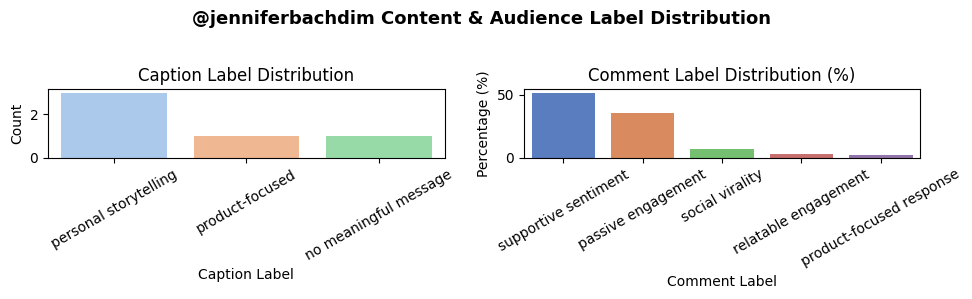

   🔁 Conversion Potential for @jenniferbachdim
   
   💬 Comment Quality
   Total 129 komentar dianalisis.
   51.9% supportive sentiment
   35.7% passive engagement
   7.0% social virality
   3.1% relatable engagement
   2.3% product-focused response
   🎯 High-Value Comment Rate: 12.4%
   Cukup rendah, mengindikasikan bahwa interaksi dari audiens masih dominan pujian atau pasif.
   
   💬 Komentar Berkualitas Tinggi yang Mewakili Audiens
   
   🔹 Relatable Engagement
   Contoh:
   "I think ada tukang lagi nge bor di sebelah 😂."
   
   🔹 Product-Focused Response
   Contoh:
   "Mama jen daftar apa? Pocari?"
   
   🔹 Social Virality
   Contoh:
   "Dari hate lari pasti lama lama cinta lari kak @jenniferbachdim 😍🔥"
   
   📢 Caption Behavior Summary – Influencer: jenniferbachdim
   
   🔁 Call-to-Action Habit:
   0 dari 5 caption mengandung CTA.
   
   🎭 Tone of Voice:
   Dominan: personal storytelling.
   Contoh:
   "Moms can relate, any kind of spot can totally throw me off 😅 Especially when 

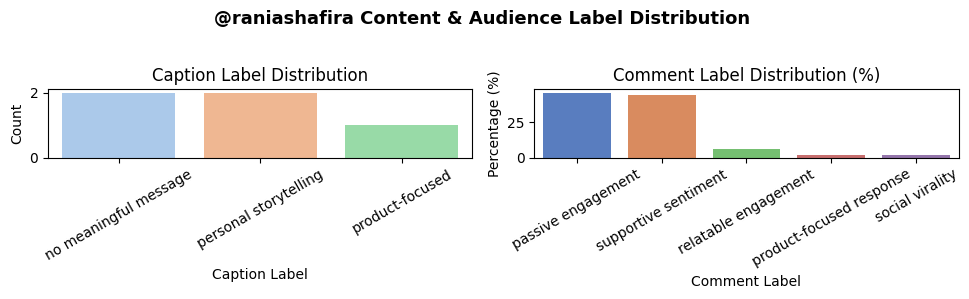

   🔁 Conversion Potential for @raniashafira
   
   💬 Comment Quality
   Total 65 komentar dianalisis.
   46.2% passive engagement
   44.6% supportive sentiment
   6.2% relatable engagement
   1.5% product-focused response
   1.5% social virality
   🎯 High-Value Comment Rate: 9.2%
   Cukup rendah, mengindikasikan bahwa interaksi dari audiens masih dominan pujian atau pasif.
   
   💬 Komentar Berkualitas Tinggi yang Mewakili Audiens
   
   🔹 Relatable Engagement
   Contoh:
   "Ran anjir cantik bgt rambut pendek"
   
   🔹 Product-Focused Response
   Contoh:
   "Best deal yaaa 😭💘💘💘💘"
   
   🔹 Social Virality
   Contoh:
   "yuuuuk @sabrinafaradis @talitharisya"
   
   📢 Caption Behavior Summary – Influencer: raniashafira
   
   🔁 Call-to-Action Habit:
   0 dari 5 caption mengandung CTA.
   
   🎭 Tone of Voice:
   Dominan: no meaningful message.
   Contoh:
   "nothing but love for @blpbeauty..."
   
   📊 Distribusi label utama:
   no meaningful message: 2
   personal storytelling: 2
   produ

In [14]:
# Example 1: Menggunakan JSON brief dengan Adaptive Weights + Output Requirements

print("🎯 EXAMPLE 1: BEAUTY BRAND WITH ADAPTIVE WEIGHTS")
print("=" * 80)

# Custom priorities untuk perbandingan (akan di-override oleh adaptive weights)
custom_priorities = {
    'persona_fit': 0.15,
    'audience_fit': 0.45,
    'performance_pred': 0.30,
    'budget_efficiency': 0.10
}

try:
    result_adaptive = process_json_brief_input(
        json_brief_input=sample_json_brief,
        influencers_df=df_instagram_influencers,
        caption_df=df_labeled_caption,
        comment_df=df_labeled_comment,
        bio_df=df_bio,
        brief_priorities=custom_priorities,
        use_adaptive_weights=True
    )

except Exception as e:
    print(f"\n❌ ERROR: {str(e)}")
    print(f"📝 Please check the input format and data availability")